<p style="font-size:20px;">Simulator: QiskitAer, FakeTorino, ideal device noise simulator (no shot noise). H4(rectangular) in minimal basis (STO-3G), JW mapping, 3-layered tUPS. With zero-parameters as well as biasing parameters for training set, number of parameters is 27. Fitting methods: Square regression with a linear ansatz, add-and-subtract.</p>

In [1]:
import pyscf
import slowquant.SlowQuant as sq
from qiskit_nature.second_q.mappers import JordanWignerMapper
from slowquant.qiskit_interface.interface import QuantumInterface
from slowquant.qiskit_interface.wavefunction import WaveFunction
from slowquant.unitary_coupled_cluster.ups_wavefunction import WaveFunctionUPS
#from slowquant.qiskit_interface.linear_response.projected import quantumLR

from qiskit_ibm_runtime.fake_provider import FakeTorino

from qiskit.primitives import Estimator

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler
from qiskit_aer.primitives import SamplerV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [10]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 1.5 0.0 0.0;
                      H 0.0 1.8 0.0;
                      H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

sampler = Estimator()
primitive = sampler
mapper = JordanWignerMapper()
# For H4 you can make the wavefunction better by increasing n_layers.
# n_layers: 3 will prob. give almost the FCI solution.
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 3, "do_pp": True}, ISA = True)

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    #include_active_kappa = True
)

#WF.run_vqe_2step("RotoSolve", maxiter=3)
#WF.run_vqe_2step("SLSQP", maxiter=40)
WF.ansatz_parameters = [3.142800380570141, 2.802123553483023, 3.141844220036336, 3.1415016877195234, 2.7699109323169533, 3.140289037489865, 1.5722892785591813, -0.05183267369041262, -3.139930460730367, -3.05193091891377, 0.07499512879186974, 0.26977250393898994, -2.875485939584386, -0.18478422435886988, 0.21835082743355141, -3.145279642647945, 0.2027868009455131, 3.141049426792193, -2.802097303067954, -0.20245039509840054, 0.14415193008627167, 0.24779481988227897, -0.04867618752527981, -3.0111535837495227, -3.1367777510378136, -0.21605050555915123, -3.14472880076259]
optimized_parameters = WF.ansatz_parameters
#no noise
nonclif_ground_state_energy = WF.energy_elec
print("Non-Clifford Ground state energy:", nonclif_ground_state_energy)

#device noise
# Update the primitive with simulated noise
backend = FakeTorino()
QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)    
# Calculate the ground state energy using the noisy simulator
noisy_nonclif_ground_state_energy = WF.energy_elec
print("Noisy Non-Clifford Ground state energy:",noisy_nonclif_ground_state_energy)

converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3


/tmp/ipykernel_2656098/3545999174.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


Non-Clifford Ground state energy: -3.712497370567829
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     405
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['cz', 'measure', 'x', 'id', 'reset', 'sx']>)

Noisy Non-Clifford Ground state energy: -2.9354609200029995


In [11]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 1.5 0.0 0.0;
                      H 0.0 1.8 0.0;
                      H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

primitive = Estimator()
mapper = JordanWignerMapper()
# For H4 you can make the wavefunction better by increasing n_layers.
# n_layers: 3 will prob. give almost the FCI solution.
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 3, "do_pp": True}, ISA = True)

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    #include_active_kappa = True
)

print(WF.ansatz_parameters)

clifford_ground_state_energy = WF.energy_elec
print('Clifford ground state energy:', clifford_ground_state_energy)

QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)
noisy_clifford_ground_state_energy = WF.energy_elec
print("Noisy clifford ground state energy:", noisy_clifford_ground_state_energy)


converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/tmp/ipykernel_2656098/1615247722.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Clifford ground state energy: -3.289581357882592
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     405
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['cz', 'measure', 'x', 'id', 'reset', 'sx']>)

Noisy clifford ground state energy: -2.993296674468803


In [12]:
AS_prediction = noisy_nonclif_ground_state_energy + clifford_ground_state_energy - noisy_clifford_ground_state_energy
print('AS prediction:', AS_prediction)

AS prediction: -3.231745603416789


In [5]:
#square regression with a linear ansatz
def cost_function(a, X_exact, X_noisy):
    a1, a2 = a  # 将参数 a 拆分为 a1 和 a2
    # 计算代价函数 C 的值
    C = (X_exact - (a1 * X_noisy + a2))**2
    return C
X_exact = np.array(clifford_ground_state_energy)
X_noisy = np.array(noisy_clifford_ground_state_energy)
# 初始猜测值 a1 和 a2
initial_guess = [1, 0]
# 最小化代价函数
result = minimize(cost_function, initial_guess, args=(X_exact, X_noisy))
# 得到最优的 a1 和 a2
a1_optimal, a2_optimal = result.x
print(f"最优的 a1 值: {a1_optimal}")
print(f"最优的 a2 值: {a2_optimal}")
y_pred_linear = a1_optimal*noisy_nonclif_ground_state_energy + a2_optimal
print('result of square regression:', y_pred_linear)

最优的 a1 值: 1.0890445564352824
最优的 a2 值: -0.029747992760151217
result of square regression: -3.144720990404919


In [13]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 1.5 0.0 0.0;
                      H 0.0 1.8 0.0;
                      H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

sampler = Estimator()
primitive = sampler
mapper = JordanWignerMapper()
# For H4 you can make the wavefunction better by increasing n_layers.
# n_layers: 3 will prob. give almost the FCI solution.
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 3, "do_pp": True}, ISA = True)

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    #include_active_kappa = True
)
WF.ansatz_parameters = optimized_parameters

for i in range(len(optimized_parameters)):
    if 0 < optimized_parameters[i] < np.pi/4:
        WF.ansatz_parameters[i] = 0 
    elif np.pi/4 < optimized_parameters[i] < (np.pi*3)/4:
        WF.ansatz_parameters[i] = np.pi/2
    elif (np.pi*3)/4 < optimized_parameters[i] < (np.pi*5)/4:
        WF.ansatz_parameters[i] = np.pi
    elif (np.pi*5)/4 < optimized_parameters[i] < (np.pi*7)/4:
        WF.ansatz_parameters[i] = (np.pi*3)/2
    elif (np.pi*7)/4 < optimized_parameters[i] < np.pi*2:
        WF.ansatz_parameters[i] = 0
    elif -np.pi/4 < optimized_parameters[i] < 0:
        WF.ansatz_parameters[i] = 0
    elif -(np.pi*3)/4 < optimized_parameters[i] < -np.pi/4:
        WF.ansatz_parameters[i] = -np.pi/2
    elif -(np.pi*5)/4 < optimized_parameters[i] < -(np.pi*3)/4:
        WF.ansatz_parameters[i] = -np.pi
    elif -(np.pi*7)/4 < optimized_parameters[i] < -(np.pi*5)/4:
        WF.ansatz_parameters[i] = -(np.pi*3)/2
    elif -np.pi*2 < optimized_parameters[i] < -(np.pi*7)/4:
        WF.ansatz_parameters[i] = 0
    
    for n in range(9):
        if i == 1 + 3*n:
            m = optimized_parameters[i]/4
            if 0 < m < np.pi/4:
                m = 0
                WF.ansatz_parameters[i] = 4 * m 
            elif np.pi/4 < m < (np.pi*3)/4:
                m = np.pi/2
                WF.ansatz_parameters[i] = 4 * m
            elif (np.pi*3)/4 < m < (np.pi*5)/4:
                m = np.pi
                WF.ansatz_parameters[i] = 4 * m
            elif -np.pi/4 < 0:
                m = 0
                WF.ansatz_parameters[i] = 4 * m
            elif -(np.pi*3)/4 < m < -np.pi/4:
                m = -np.pi/2
                WF.ansatz_parameters[i] = 4 * m
            elif -(np.pi*5)/4 < m < -(np.pi*3)/4:
                m = -np.pi
                WF.ansatz_parameters[i] = 4 * m

print(WF.ansatz_parameters)

clifford_ground_state_energy = WF.energy_elec
print(clifford_ground_state_energy)

backend = FakeTorino()
QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)
noisy_clifford_ground_state_energy = WF.energy_elec
print(noisy_clifford_ground_state_energy)

converged SCF energy = -1.77674731624872


Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793, 1.5707963267948966, 0, -3.141592653589793, -3.141592653589793, 0, 0, -3.141592653589793, 0, 0, -3.141592653589793, 0, 3.141592653589793, -3.141592653589793, 0, 0, 0, 0, -3.141592653589793, -3.141592653589793, 0, -3.141592653589793]


/tmp/ipykernel_2656098/2201919526.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272957
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     405
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['cz', 'measure', 'x', 'id', 'reset', 'sx']>)

-2.9824066189372616


In [14]:
AS_bias = noisy_nonclif_ground_state_energy + clifford_ground_state_energy - noisy_clifford_ground_state_energy
print('AS prediction:', AS_bias)

AS prediction: -3.475040570793034


In [15]:
delta_zero = nonclif_ground_state_energy - AS_prediction
delta_bias = nonclif_ground_state_energy - AS_bias
print(delta_zero)
print(delta_bias)

-0.48075176715103973
-0.23745679977479472


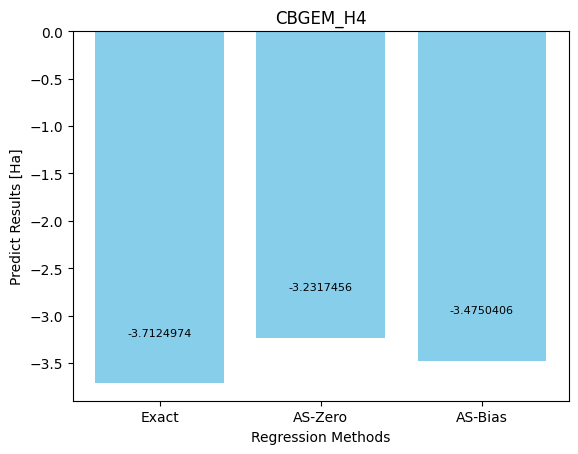

In [16]:
# 数据
categories = ['Exact', 'AS-Zero', 'AS-Bias']
values = [nonclif_ground_state_energy, AS_prediction, AS_bias]

# 绘制柱状图
plt.bar(categories, values, color='skyblue')

# 添加标题和标签
plt.title('CBGEM_H4')
plt.xlabel('Regression Methods')
plt.ylabel('Predict Results [Ha]')

# 在每个柱子上标注数值
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:.7f}", ha='center', fontsize=8)

# 显示图表
plt.show()